In [0]:
!pip install tensorflow-gpu==1.14

In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd "drive/My Drive/Colab Notebooks"

In [0]:
import cv2
from skimage.measure import compare_ssim
import imutils
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [0]:
b = cv2.imread('frame-269.jpg')
f = cv2.imread('frame-5.jpg')

In [0]:
b.shape

(1080, 1920, 3)

In [0]:
height, width = b.shape[:2]
print(height, width)

1080 1920


In [0]:
start_row, start_col = int(height * .5), int(0)
# Let's get the ending pixel coordinates (bottom right of cropped bottom)
end_row, end_col = int(height), int(width)
b = b[start_row:end_row , start_col:end_col]
f = f[start_row:end_row , start_col:end_col]

In [0]:

# b = b.convert('RGB')
# b = b.resize((800, 600), Image.ANTIALIAS)

# f = f.convert('RGB')
# f = f.resize((800, 600), Image.ANTIALIAS)

# background = np.array(b)
# foreground = np.array(f)

background = b
foreground = f


# background = cv2.imread('background.png')
# foreground = cv2.imread('foreground.png')

print(background.shape)
print(foreground.shape)

(540, 1920, 3)
(540, 1920, 3)


In [0]:
gray_bg = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)
gray_fg = cv2.cvtColor(foreground, cv2.COLOR_BGR2GRAY)

(score, diff) = compare_ssim(gray_bg, gray_fg, full=True)
diff = (diff * 255).astype("uint8")
print("SSIM: {}".format(score))

SSIM: 0.7057434130841755


In [0]:
thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

In [0]:
# loop over the contours
rois = []
for c in cnts:
    # compute the bounding box of the contour and then draw the
    # bounding box on both input images to represent where the two
    # images differ
    if cv2.contourArea(c) < 300:
        continue
    (x, y, w, h) = cv2.boundingRect(c)
    rois.append(foreground.copy()[y:y+h, x:x+w])
    cv2.rectangle(background, (x, y), (x + w, y + h), (0, 0, 255), 2)
    cv2.rectangle(foreground, (x, y), (x + w, y + h), (0, 0, 255), 2)

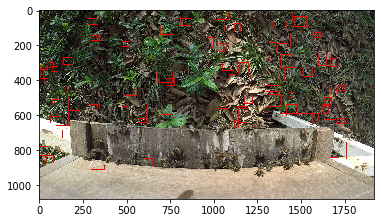

In [0]:
plt.imshow(cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB))
plt.show()

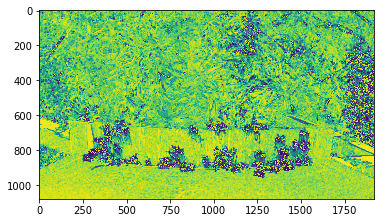

In [0]:
plt.imshow(diff)
plt.show()

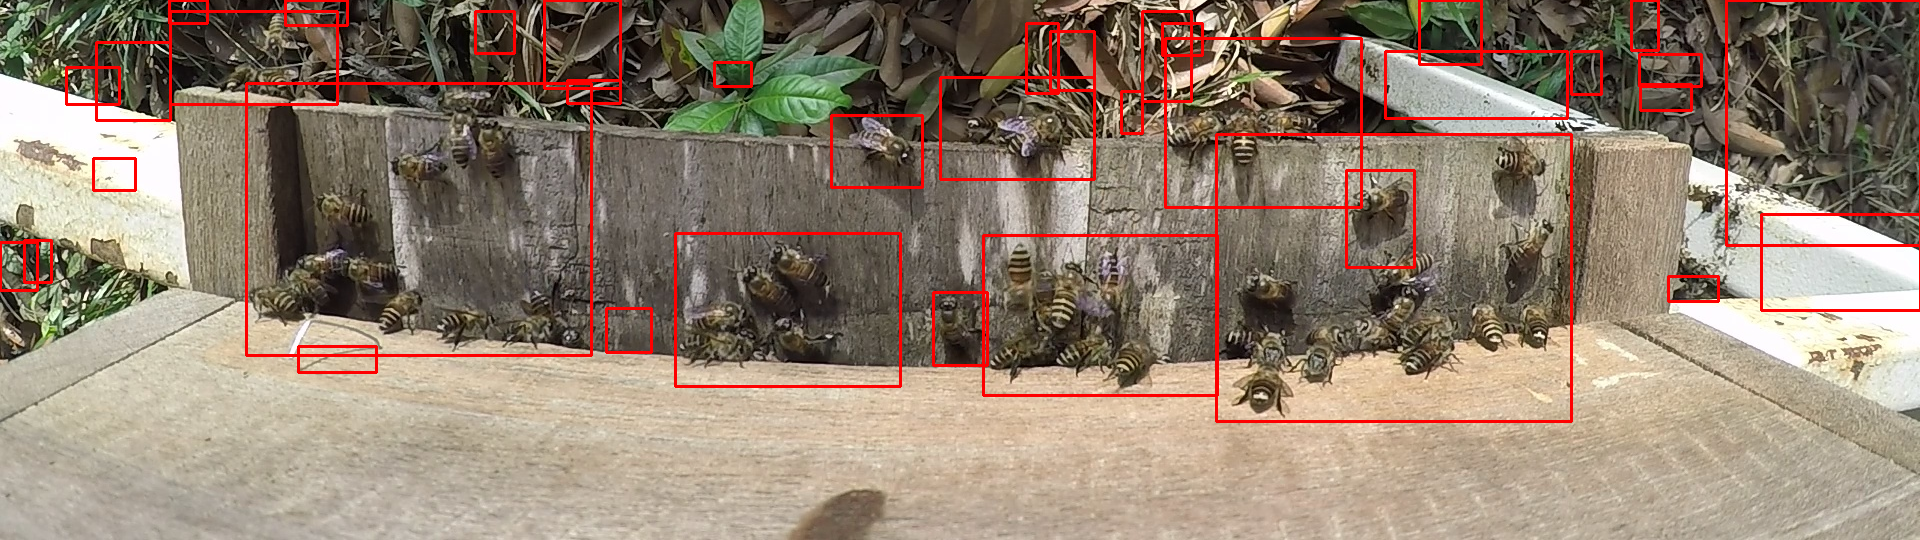

In [0]:
from google.colab.patches import cv2_imshow

# cv2_imshow(cv2.cvtColor(diff, cv2.COLOR_BAYER_BG2BGR))
cv2.imwrite('background subtraction bounding box halved.jpg', foreground)
cv2_imshow(foreground)
# plt.show()

In [0]:
from google.colab.patches import cv2_imshow

def create_countour_images(b, f):
    height, width = b.shape[:2]
    start_row, start_col = int(height * .5), int(0)
    end_row, end_col = int(height), int(width)
    
#     b = b[start_row:end_row , start_col:end_col]
#     f = f[start_row:end_row , start_col:end_col]
    
    background = np.array(b)
    foreground = np.array(f)
    
    gray_bg = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)
    gray_fg = cv2.cvtColor(foreground, cv2.COLOR_BGR2GRAY)

    (score, diff) = compare_ssim(gray_bg, gray_fg, full=True)
    diff = (diff * 255).astype("uint8")
    
#     thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
#     cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     cnts = imutils.grab_contours(cnts)
    
#     # loop over the contours
#     rois = []
#     for c in cnts:
#         # compute the bounding box of the contour and then draw the
#         # bounding box on both input images to represent where the two
#         # images differ
#     #     if cv2.contourArea(c) < 100 :
#     #         continue
#         (x, y, w, h) = cv2.boundingRect(c)
#         rois.append(foreground.copy()[y:y+h, x:x+w])
#         cv2.rectangle(background, (x, y), (x + w, y + h), (0, 0, 255), 2)
#         cv2.rectangle(foreground, (x, y), (x + w, y + h), (0, 0, 255), 2)
    diff = cv2.cvtColor(diff, cv2.COLOR_BAYER_BG2BGR)
    return diff
#     cv2_imshow(diff)

In [0]:
import os

imgs_dir = 'MARDI-dataset/test/images/'
new_imgs_dir = 'MARDI-dataset/diff/images/'

b = cv2.imread('frame-269.jpg')

for d in os.listdir(imgs_dir):
    print(imgs_dir + d)
    f = cv2.imread(imgs_dir + d)
    diff = create_countour_images(b, f)
    cv2.imwrite(new_imgs_dir + d, diff)

In [0]:
create_countour_images(b, f)

In [0]:
from boundbox import BoundBox
# from architecture import BaseNet
from tensorflow.keras.models import load_model
from utils import *

In [0]:
anchors = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]
# base_net = BaseNet(net_input_size=1080, 
#                        anchors=anchors, 
#                        n_class=2, 
#                        weights_dir=None, 
#                        labels=['bee-A', 'bee-B'])

model = load_model("mobilenet-2class-bees-model.h5", compile=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
imgs, annot = parse_annotation('MARDI-dataset/test/annotations/', 'MARDI-dataset/test/images/', ['bee-A', 'bee-B'])
imgs = imgs[:80]
print(len(imgs))

def predict(model, img):
    background = cv2.imread('frame-269.jpg')
    
    foreground = cv2.imread(img)
    
    
    gray_bg = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)
    gray_fg = cv2.cvtColor(foreground, cv2.COLOR_BGR2GRAY)

    
#     print(gray_fg.shape)
#     print(gray_bg.shape)
    
    (score, diff) = compare_ssim(gray_bg, gray_fg, full=True)
    diff = (diff * 255).astype("uint8")
    thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    pred_boxes = []
    
    # loop over the contours
    rois = []
    for c in cnts:
        # compute the bounding box of the contour and then draw the
        # bounding box on both input images to represent where the two
        # images differ
        if cv2.contourArea(c) < 300:
            continue
        (x, y, w, h) = cv2.boundingRect(c)
        
#         if y < 540:
#             continue
#         print(x, y, w, h)
        cropped = foreground.copy()[y: y + h, x: x + w]
        cropped = cv2.resize(cropped, (128,128))
#         cv2_imshow(cropped)
#         return
        cropped = np.expand_dims(cropped, axis=0)
        pred_classes = model.predict(cropped)
        pred_boxes.append(BoundBox(x, y, x + w, y + h, 1, pred_classes))
    return pred_boxes

def evaluate(model, imgs):
    n_class = 2
    labels = ['bee-A', 'bee-B']
    test_size = len(imgs)

    all_detections     = [[None for i in range(n_class)] for j in range(test_size)]
    all_annotations    = [[None for i in range(n_class)] for j in range(test_size)]

    for i in range(test_size):
        print(i)
        image_name = imgs[i]['filename']
			
        if '.jpg' not in image_name and '.png' not in image_name:
            image_name += '.jpg'

        raw_image = cv2.imread(image_name)

        raw_height, raw_width, raw_channels = raw_image.shape
        
        pred_boxes = predict(model, image_name)
        
        score = np.array([box.score for box in pred_boxes])
        pred_labels = np.array([box.label for box in pred_boxes])        

        if len(pred_boxes) > 0:
            pred_boxes = np.array([[box.xmin*raw_width, 
                box.ymin*raw_height, 
                box.xmax*raw_width, 
                box.ymax*raw_height, 
                box.score] for box in pred_boxes])
        else:
            pred_boxes = np.array([[]])  

        # sort the boxes and the labels according to scores
        score_sort = np.argsort(-score)
        pred_labels = pred_labels[score_sort]
        pred_boxes  = pred_boxes[score_sort]

        # copy detections to all_detections
        for label in range(n_class):
            all_detections[i][label] = pred_boxes[pred_labels == label, :]

        annotations = load_annotation(imgs, i, labels)

        # copy detections to all_annotations
        for label in range(n_class):
            all_annotations[i][label] = annotations[annotations[:, 4] == label, :4].copy()

    # compute mAP by comparing all detections and all annotations
    average_precisions = {}

    for label in range(n_class):
        false_positives = np.zeros((0,))
        true_positives  = np.zeros((0,))
        scores          = np.zeros((0,))
        num_annotations = 0.0

        for i in range(test_size):
            detections           = all_detections[i][label]
            annotations          = all_annotations[i][label]
            num_annotations     += annotations.shape[0]
            detected_annotations = []

            for d in detections:
                scores = np.append(scores, d[4])

                if annotations.shape[0] == 0:
                    false_positives = np.append(false_positives, 1)
                    true_positives  = np.append(true_positives, 0)
                    continue

                overlaps            = compute_overlap(np.expand_dims(d, axis=0), annotations)
                assigned_annotation = np.argmax(overlaps, axis=1)
                max_overlap         = overlaps[0, assigned_annotation]

                if max_overlap >= iou_threshold and assigned_annotation not in detected_annotations:
                    false_positives = np.append(false_positives, 0)
                    true_positives  = np.append(true_positives, 1)
                    detected_annotations.append(assigned_annotation)
                else:
                    false_positives = np.append(false_positives, 1)
                    true_positives  = np.append(true_positives, 0)

        # no annotations -> AP for this class is 0 (is this correct?)
        if num_annotations == 0:
            average_precisions[label] = 0
            continue

        # sort by score
        indices         = np.argsort(-scores)
        false_positives = false_positives[indices]
        true_positives  = true_positives[indices]

        # compute false positives and true positives
        false_positives = np.cumsum(false_positives)
        true_positives  = np.cumsum(true_positives)

        # compute recall and precision
        recall    = true_positives / num_annotations
        precision = true_positives / np.maximum(true_positives + false_positives, np.finfo(np.float64).eps)

        # compute average precision
        average_precision  = compute_ap(recall, precision)  
        average_precisions[label] = average_precision


    # print evaluation
    for label, average_precision in average_precisions.items():
        print(labels[label], '{:.4f}'.format(average_precision))
    print('mAP: {:f}'.format(sum(average_precisions.values()) / len(average_precisions)))

In [0]:
evaluate(model, imgs)